In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker

pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [2]:
#CONSTANTS

# to do: change the rates so that there are company specific values as well (for 2019, need Via rates), maybe store in a dataframe

NON_WAV_PER_MILE_22 = 1.161
NON_WAV_PER_MIN_22 = 0.529

WAV_PER_MILE_22 = 1.504
WAV_PER_MIN_22 = 0.529

OUT_CITY_NON_WAV_PER_MILE_22 = 1.348
OUT_CITY_WAV_PER_MILE_22 = 1.746
OUT_CITY_PER_MIN_22 = 0.613


NON_WAV_PER_MILE_19 = 1.088
NON_WAV_PER_MIN_19 = 0.495

WAV_PER_MILE_19 = 1.410
WAV_PER_MIN_19 = 0.495

OUT_CITY_NON_WAV_PER_MILE_19 = 1.262
OUT_CITY_WAV_PER_MILE_19 = 1.636
OUT_CITY_PER_MIN_19 = 0.574

JUNO = "HV0002"
UBER = "HV0003"
VIA = "HV0004"
LYFT = "HV0005"

# 2019 (not adjusted)

In [3]:
# Import Cleaned Data

rides2019 = pq.read_table("../Aya_NYTWA/Data/february_2019_cleaned.parquet", memory_map=True).to_pandas()

In [4]:
# Create minimum rates 2019 based on WAV and Out of City Conditions

conditions2019 = [
    (rides2019['wav_match_flag'] == 'N') & (rides2019['out_of_city'] == False),
    (rides2019['wav_match_flag'] == 'Y') & (rides2019['out_of_city'] == False),
    (rides2019['wav_match_flag'] == 'N') & (rides2019['out_of_city'] == True),
    (rides2019['wav_match_flag'] == 'Y') & (rides2019['out_of_city'] == True)]

choices2019 = [rides2019.trip_miles*NON_WAV_PER_MILE_19 + (rides2019.trip_time/60)*NON_WAV_PER_MIN_19,
              rides2019.trip_miles*WAV_PER_MILE_19 + (rides2019.trip_time/60)*WAV_PER_MIN_19,
              rides2019.trip_miles*OUT_CITY_NON_WAV_PER_MILE_19 + (rides2019.trip_time/60)*OUT_CITY_PER_MIN_19,
              rides2019.trip_miles*OUT_CITY_WAV_PER_MILE_19 + (rides2019.trip_time/60)*OUT_CITY_PER_MIN_19]

rides2019['min_rate'] = np.select(conditions2019, choices2019, default=rides2019.trip_miles*NON_WAV_PER_MILE_19 + (rides2019.trip_time/60)*NON_WAV_PER_MIN_19)



## Driver pay analysis

#### Distribution of driver pay

In [5]:
# Total driver pay across all rides

rides2019['driver_pay'].sum()    

277142674.98999953

In [6]:
# Create variable for dollar amount of driver pay over min rate

rides2019['over_min_rate'] = (rides2019.driver_pay - rides2019.min_rate)

In [7]:
# Create variable for percentage of driver pay over min rate

rides2019['perc_over_min_rate'] = (rides2019.over_min_rate/rides2019.min_rate)

In [8]:
# Create rate of passenger fare, by mile and minute

rides2019['passenger_fare_mile'] = rides2019.base_passenger_fare/rides2019.trip_miles
rides2019['passenger_fare_min'] = rides2019.base_passenger_fare/(rides2019.trip_time/60)

In [9]:
# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

rides2019 = rides2019.loc[rides2019['shared_match_flag'] == "N"]
rides2019 = rides2019.loc[rides2019['hvfhs_license_num'] != VIA]
rides2019 = rides2019.loc[rides2019['out_of_city'] == False]

In [10]:
rides2019.driver_pay.describe()

count   14008641.00000
mean          15.03863
std           12.31794
min            0.03000
25%            6.88000
50%           10.99000
75%           18.40000
max          708.63000
Name: driver_pay, dtype: float64

In [ ]:
rides2019.min_rate.describe()

#### Distribution of percentage of driver earnings over the minimum required rate for the trip (In 2022 the bottom 25% of trips made less than 0.5% over the minimum rate, the top 25% of trips made at least 30% over the minimum rate, and the median percent made over the minimum rate was 7%)

In [ ]:
rides2019.perc_over_min_rate.describe()

In [11]:
bin_labels = ['less than 0%', '0% - 5%','5% - 10%', '10% - 15%', '15% and over']
bins = [float('-inf'), 0, 0.05, 0.10, 0.15, float('inf')]

rides2019['perc_over_range'] = pd.cut(rides2019['perc_over_min_rate'], bins= bins, labels=bin_labels)

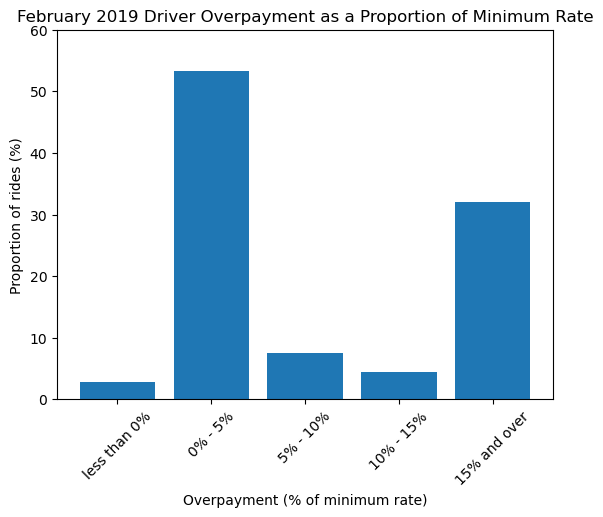

In [12]:
plt.bar(bin_labels, rides2019.groupby("perc_over_range")["perc_over_range"].count()*100/len(rides2019["perc_over_range"]))
plt.ylim([0, 60])
plt.xticks(rotation = 45)
plt.xlabel('Overpayment (% of minimum rate)')
plt.ylabel('Proportion of rides (%)')
plt.title('February 2019 Driver Overpayment as a Proportion of Minimum Rate')

plt.show()

#### !! Percentage of rides where the driver made less than the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate < 0])/len(rides2019)

#### !! Percentage of rides where the driver made 1% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= 0.01])/len(rides2019)

#### !! Percentage of rides where the driver made 10% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= 0.10])/len(rides2019)

#### !! Percentage of rides where the driver made 20% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= 0.20])/len(rides2019)

#### Percentage of rides where the driver made more than 5% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate > 0.05])/len(rides2019)

#### Percentage of rides where the driver made more than 10% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate > 0.10])/len(rides2019)

#### Percentage of rides where the driver made more than 20% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate > 0.20])/len(rides2019)

#### Distribution of driver pay for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].driver_pay.describe()

#### Distribution of underpayment for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].over_min_rate.describe()

#### (NEW) Distribution of proportion underpaid for rides where the driver made less than the minimum rate

In [10]:
rides2019[rides2019.perc_over_min_rate < 0].perc_over_min_rate.describe()

count   390187.00000
mean        -0.05744
std          0.09937
min         -0.99931
25%         -0.08611
50%         -0.02423
75%         -0.00028
max         -0.00000
Name: perc_over_min_rate, dtype: float64

#### Total dollar amount underpaid

In [26]:
(rides2019[rides2019.perc_over_min_rate < 0]["over_min_rate"] * -1).sum()

505981.2975000003

#### Percent of underpaid trips underpaid by 1% or more

In [17]:
num_underpaid = len(rides2019[rides2019.perc_over_min_rate < 0])

len(rides2019[rides2019.perc_over_min_rate <= -0.01])/num_underpaid

0.5533859405874619

#### Percent of underpaid trips underpaid by 2% or more

In [18]:
len(rides2019[rides2019.perc_over_min_rate <= -0.02])/num_underpaid

0.5153349547780935

#### Percent of underpaid trips underpaid by 5% or more

In [19]:
len(rides2019[rides2019.perc_over_min_rate <= -0.05])/num_underpaid

0.3959588607513833

#### Percent of underpaid trips underpaid by 10% or more

In [21]:
len(rides2019[rides2019.perc_over_min_rate <= -0.10])/num_underpaid

0.19980932219679282

#### Percent of underpaid trips underpaid by 25% or more

In [23]:
len(rides2019[rides2019.perc_over_min_rate <= -0.25])/num_underpaid

0.029911298941276875

#### Percent of underpaid trips underpaid by 50% or more

In [22]:
len(rides2019[rides2019.perc_over_min_rate <= -0.50])/num_underpaid

0.012019877648409609

#### Distribution of minimum rate (in dollars) for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].min_rate.describe()

#### Distribution of ride length (in miles) for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].trip_miles.describe()

#### (NEW) Distribution of ride length (in minutes) for rides where the driver made less than minimum rate

In [ ]:
rides2019["trip_time_min"] = rides2019["trip_time"]/60
rides2019[rides2019.perc_over_min_rate < 0]["trip_time_min"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2].driver_pay.describe()

#### Distribution of overage (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2]["over_min_rate"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2]["min_rate"].describe()

#### !! Percent of trips where overage is more than \$1

In [ ]:
len(rides2019[rides2019['over_min_rate'] > 1])/len(rides2019)

#### !! Percent of trips where overage was \$20 or more

In [ ]:
len(rides2019[rides2019['over_min_rate'] > 20])/len(rides2019)

#### !! Average overage of all trips in dollars

In [ ]:
rides2019['over_min_rate'].describe()

#### !! Average overage of trips that were 10% or less over in dollars

In [ ]:
rides2019[rides2019['perc_over_min_rate'] < .1]['over_min_rate'].describe()

#### !! Average overage of all trips which are over pay rules in dollars

In [ ]:
rides2019[rides2019['over_min_rate'] > 0]['over_min_rate'].describe()

## Passenger Fare Analysis

In [ ]:
# Total passenger fare across all rides

rides2019['base_passenger_fare'].sum()    

In [ ]:
rides2019['passenger_fare_mile'] = rides2019.base_passenger_fare/rides2019.trip_miles
rides2019['passenger_fare_min'] = rides2019.base_passenger_fare/(rides2019.trip_time/60)

#### Distribution of passenger fare

In [ ]:
rides2019.base_passenger_fare.describe()

#### Average fare per minute cost 

In [ ]:
np.mean(rides2019['passenger_fare_min'])

#### Average fare per mile cost

In [ ]:
np.mean(rides2019['passenger_fare_mile'])

#### Regression of minutes and miles by passenger fare (In 2022, each additional mile per trip increases the fare by 2.03 dollars and each additional minute per trip increases the fare by 0.47 dollars)



In [ ]:
# convert trip time to minutes
rides2019['trip_time_min'] = rides2019.trip_time/60

In [ ]:
result = sm.ols(formula="base_passenger_fare ~ trip_miles + trip_time_min", data=rides2019).fit()
print(result.params)

## Drivers' earnings compared to passenger fare

In [ ]:
rides2019['perc_earnings_fare'] = rides2019["driver_pay"]/rides2019["base_passenger_fare"]

rides2019["perc_earnings_fare"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare"] > 1]["driver_pay"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare"] < 1]["driver_pay"].describe()

In [ ]:
len(rides2019[rides2019["perc_earnings_fare"] > 1])/len(rides2019["perc_earnings_fare"])

### Plot of proportion of passenger fare that the company takes

In [13]:
rides2019['perc_uber_takes'] = 1 - rides2019["driver_pay"]/rides2019["base_passenger_fare"]

In [14]:
bin_labels = ['less than 0%', '0% - 10%','10% - 20%', '20% - 30%', '30% - 40%', '40% and over']
bins = [float('-inf'), 0, 0.10, 0.20, 0.30, 0.40, float('inf')]

rides2019['perc_uber_takes_range'] = pd.cut(rides2019['perc_uber_takes'], bins= bins, labels=bin_labels)

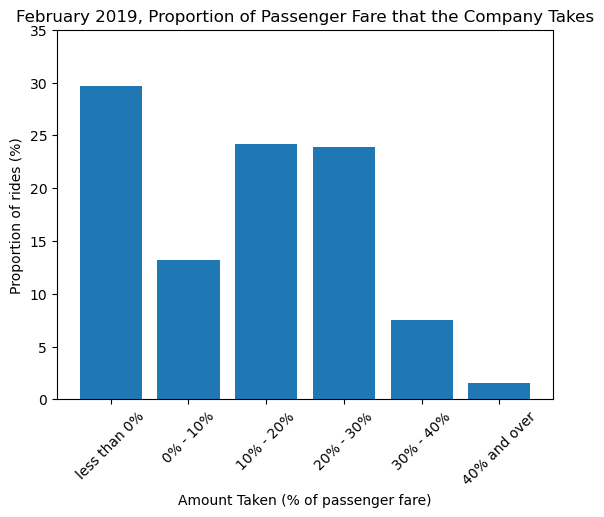

In [15]:
plt.bar(bin_labels, rides2019.groupby("perc_uber_takes_range")["perc_uber_takes_range"].count()*100/len(rides2019["perc_uber_takes_range"]))
plt.xticks(rotation = 45)
plt.ylim([0, 35])
plt.xlabel('Amount Taken (% of passenger fare)')
plt.ylabel('Proportion of rides (%)')
plt.title('February 2019, Proportion of Passenger Fare that the Company Takes')

plt.show()

## Trip lengths

In [ ]:
rides2019["trip_time_min"].describe()

In [ ]:
rides2019["trip_miles"].describe()

# 2019 (adjusted)

## Driver pay analysis

In [ ]:
# adjust 2019 data to 2022 dollar inflation rate

rides2019['driver_pay_adj'] = rides2019.driver_pay * 1.159 #inflation rate between 2019 and 2022

In [ ]:
# Total driver pay across all rides

rides2019['driver_pay_adj'].sum()    

In [ ]:
# Create dollar amount of min rate adjusted to inflation

rides2019['min_rate_adj'] = rides2019.min_rate * 1.159

In [ ]:
# Create variable for dollar amount of driver pay over min rate

rides2019['over_min_rate_adj'] = (rides2019.driver_pay_adj - rides2019.min_rate * 1.159)

In [ ]:
# Create variable for percentage of driver pay over min rate

rides2019['perc_over_min_rate_adj'] = (rides2019.over_min_rate_adj/(rides2019.min_rate * 1.159))

In [ ]:
# Create rate of passenger fare, by mile and minute

rides2019['passenger_fare_mile_adj'] = rides2019.base_passenger_fare * 1.159/rides2019.trip_miles
rides2019['passenger_fare_min_adj'] = rides2019.base_passenger_fare * 1.159/(rides2019.trip_time/60)

In [ ]:
# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

rides2019 = rides2019.loc[rides2019['shared_match_flag'] == "N"]
rides2019 = rides2019.loc[rides2019['hvfhs_license_num'] != VIA]
rides2019 = rides2019.loc[rides2019['out_of_city'] == False]

In [ ]:
rides2019.driver_pay_adj.describe()

#### Distribution of percentage of driver earnings over the minimum required rate for the trip (In 2022 the bottom 25% of trips made less than 0.5% over the minimum rate, the top 25% of trips made at least 30% over the minimum rate, and the median percent made over the minimum rate was 7%)

In [ ]:
rides2019.perc_over_min_rate_adj.describe()

#### !! Percentage of rides where the driver made less than the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj < 0])/len(rides2019)

#### !! Percentage of rides where the driver made 1% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj <= 0.01])/len(rides2019)

#### !! Percentage of rides where the driver made 10% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj <= 0.10])/len(rides2019)

#### Percentage of rides where the driver made more than 5% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj > 0.05])/len(rides2019)

#### Percentage of rides where the driver made more than 10% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj > 0.10])/len(rides2019)

#### Percentage of rides where the driver made more than 20% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj > 0.20])/len(rides2019)

#### Distribution of driver pay for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].driver_pay_adj.describe()

#### Distribution of underpayment for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].over_min_rate_adj.describe()

#### (NEW) Distribution of proportion underpaid for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0]["perc_over_min_rate_adj"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].min_rate_adj.describe()

#### Distribution of ride length for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].trip_miles.describe()

#### (NEW) Distribution of ride length (in minutes) for rides where the driver made less than minimum rate

In [ ]:
rides2019["trip_time_min"] = rides2019["trip_time"]/60
rides2019[rides2019.perc_over_min_rate < 0]["trip_time_min"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj > .2].driver_pay_adj.describe()

#### Distribution of overage (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj > .2]["over_min_rate_adj"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2]["min_rate_adj"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate (2022 dollars)

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj > .2].driver_pay_adj.describe()

#### !! Percent of trips where overage is more than \$1

In [ ]:
len(rides2019[rides2019['over_min_rate_adj'] > 1])/len(rides2019)

#### !! Percent of trips where overage was \$20 or more

In [ ]:
len(rides2019[rides2019['over_min_rate_adj'] > 20])/len(rides2019)

#### !! Average overage of all trips in dollars

In [ ]:
rides2019['over_min_rate_adj'].describe()

#### !! Average overage of trips that were 10% or less over in dollars

In [ ]:
rides2019[rides2019['perc_over_min_rate_adj'] < .1]['over_min_rate_adj'].describe()

#### !! Average overage of all trips which are over pay rules in dollars

In [ ]:
rides2019[rides2019['over_min_rate_adj'] > 0]['over_min_rate_adj'].describe()

## Passenger Fare Analysis

In [ ]:
# Convert 2019 base passenger fare to 2022 dollars

rides2019['passenger_fare_adj'] = rides2019.base_passenger_fare * 1.159 #inflation rate between 2019 and 2022
rides2019['passenger_fare_mile_adj'] = rides2019.base_passenger_fare*1.159/rides2019.trip_miles
rides2019['passenger_fare_min_adj'] = rides2019.base_passenger_fare*1.159/(rides2019.trip_time/60)

In [ ]:
# Total passenger fare across all rides

rides2019['passenger_fare_adj'].sum()  

#### Distribution of passenger fare

In [ ]:
rides2019.passenger_fare_adj.describe()

#### Average fare per minute cost 

In [ ]:
np.mean(rides2019['passenger_fare_min_adj'])

#### Average fare per mile cost (2022 Dollars)

In [ ]:
np.mean(rides2019['passenger_fare_mile_adj'])

#### Regression of minutes and miles by passenger fare (In 2022, each additional mile per trip increases the fare by 2.03 dollars and each additional minute per trip increases the fare by 0.47 dollars)



In [ ]:
# convert trip time to minutes
rides2019['trip_time_min'] = rides2019.trip_time/60

In [ ]:
result = sm.ols(formula="passenger_fare_adj ~ trip_miles + trip_time_min", data=rides2019).fit()
print(result.params)

## Drivers' earnings compared to passenger fare

In [ ]:
rides2019['perc_earnings_fare_adj'] = rides2019["driver_pay_adj"]/rides2019["passenger_fare_adj"]

rides2019["perc_earnings_fare_adj"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare_adj"] > 1]["perc_earnings_fare_adj"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare_adj"] < 1]["perc_earnings_fare_adj"].describe()

## Trip lengths

In [ ]:
rides2019["trip_time_min"].describe()

In [ ]:
rides2019["trip_miles"].describe()

# 2022

In [ ]:
rides2022 = pq.read_table("../Aya_NYTWA/Data/april_2022_cleaned.parquet", memory_map=True).to_pandas()

In [ ]:
# Create minimum rates 2022 based on WAV and Out of City Conditions

conditions2022 = [
    (rides2022['wav_match_flag'] == 'N') & (rides2022['out_of_city'] == False),
    (rides2022['wav_match_flag'] == 'Y') & (rides2022['out_of_city'] == False),
    (rides2022['wav_match_flag'] == 'N') & (rides2022['out_of_city'] == True),
    (rides2022['wav_match_flag'] == 'Y') & (rides2022['out_of_city'] == True)]

choices2022 = [rides2022.trip_miles*NON_WAV_PER_MILE_22 + (rides2022.trip_time/60)*NON_WAV_PER_MIN_22,
              rides2022.trip_miles*WAV_PER_MILE_22 + (rides2022.trip_time/60)*WAV_PER_MIN_22,
              rides2022.trip_miles*OUT_CITY_NON_WAV_PER_MILE_22 + (rides2022.trip_time/60)*OUT_CITY_PER_MIN_22,
              rides2022.trip_miles*OUT_CITY_WAV_PER_MILE_22 + (rides2022.trip_time/60)*OUT_CITY_PER_MIN_22]

rides2022['min_rate'] = np.select(conditions2022, choices2022, default=rides2022.trip_miles*NON_WAV_PER_MILE_22 + (rides2022.trip_time/60)*NON_WAV_PER_MIN_22)


In [ ]:
# Create variable for dollar amount of driver pay over min rate

rides2022['over_min_rate'] = (rides2022.driver_pay - rides2022.min_rate)

In [ ]:
# Create variable for percentage of driver pay over min rate

rides2022['perc_over_min_rate'] = (rides2022.over_min_rate/rides2022.min_rate)

In [ ]:
# Create rate of passenger fare, by mile and minute


rides2022['passenger_fare_mile'] = rides2022.base_passenger_fare/rides2022.trip_miles
rides2022['passenger_fare_min'] = rides2022.base_passenger_fare/(rides2022.trip_time/60)

In [ ]:
# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

rides2022 = rides2022.loc[rides2022['hvfhs_license_num'] != VIA]

rides2022 = rides2022.loc[rides2022['out_of_city'] == False]

## Driver Pay Analysis


In [ ]:
# Total driver pay across all rides

rides2022['driver_pay'].sum()    

#### Distribution of driver pay (in 2022 dollars)

In [ ]:
rides2022.driver_pay.describe()

In [ ]:
rides.min_rate.describe()

#### Distribution of percentage of driver earnings over the minimum required rate for the trip (In 2022 the bottom 25% of trips made less than 0.5% over the minimum rate, the top 25% of trips made at least 30% over the minimum rate, and the median percent made over the minimum rate was 7%)

In [ ]:
rides2022.perc_over_min_rate.describe()

#### !! Percentage of rides where the driver made less than the minimum required rate

In [ ]:
bin_labels = ['less than 0%', '0% - 5%','5% - 10%', '10% - 15%', '15% and over']
bins = [float('-inf'), 0, 0.05, 0.10, 0.15, float('inf')]

rides2022['perc_over_range'] = pd.cut(rides2022['perc_over_min_rate'], bins= bins, labels=bin_labels)

In [ ]:
plt.bar(bin_labels, rides2022.groupby("perc_over_range")["perc_over_range"].count()*100/len(rides2022["perc_over_range"]))
plt.xticks(rotation = 45)
plt.ylim([0, 60])
plt.xlabel('Overpayment (% of minimum rate)')
plt.ylabel('Proportion of rides (%)')
plt.title('April 2022 Driver Overpayment as a Proportion of Minimum Rate')

plt.show()

In [ ]:
len(rides2022[rides2022.perc_over_min_rate < 0])/len(rides2022)

#### !! Percentage of rides where the driver made 1% or less over the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= 0.01])/len(rides2022)

#### !! Percentage of rides where the driver made 10% or less over the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= 0.10])/len(rides2022)

#### Percentage of rides where the driver made more than 5% of the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate > 0.05])/len(rides2022)

#### Percentage of rides where the driver made more than 10% of the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate > 0.10])/len(rides2022)

#### Percentage of rides where the driver made more than 20% of the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate > 0.20])/len(rides2022)

#### Distribution of driver pay for rides where the driver made less than the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].driver_pay.describe()

#### Distribution of underpayment for rides where the driver made less than the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].over_min_rate.describe()

#### (NEW) Distribution of proportion underpaid for rides where the driver made less than the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].perc_over_min_rate.describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made less than minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].min_rate.describe()

#### Distribution of ride length for rides where the driver made less than minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].trip_miles.describe()

#### (NEW) Distribution of ride length (in minutes) for rides where the driver made less than minimum rate

In [ ]:
rides2022["trip_time_min"] = rides2022["trip_time"]/60
rides2022[rides2022.perc_over_min_rate < 0]["trip_time_min"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2].driver_pay.describe()

#### Distribution of overage (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2]["over_min_rate"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2]["min_rate"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate (2022 dollars)

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2].driver_pay.describe()

#### !! Percent of trips where overage is more than \$1

In [ ]:
len(rides2022[rides2022['over_min_rate'] > 1])/len(rides2022)

#### !! Percent of trips where overage was \$20 or more

In [ ]:
len(rides2022[rides2022['over_min_rate'] > 20])/len(rides2022)

#### !! Average overage of all trips in dollars

In [ ]:
rides2022['over_min_rate'].describe()

#### !! Average overage of trips that were 10% or less over in dollars

In [ ]:
rides2022[rides2022['perc_over_min_rate'] < .1]['over_min_rate'].describe()

#### !! Average overage of all trips which are over pay rules in dollars

In [ ]:
rides2022[rides2022['over_min_rate'] > 0]['over_min_rate'].describe()

## Passenger Fare Analysis

In [ ]:
# Total passenger fare across all rides

rides2022['base_passenger_fare'].sum()  

#### Distribution of passenger fare (2022 Dollars)

In [ ]:
rides2022.base_passenger_fare.describe()

#### Average fare per minute cost (2022 Dollars)

In [ ]:
np.mean(rides2022['passenger_fare_min'])

#### Average fare per mile cost (2022 Dollars)

In [ ]:
np.mean(rides2022['passenger_fare_mile'])

#### Regression of minutes and miles by passenger fare (In 2022, each additional mile per trip increases the fare by 2.03 dollars and each additional minute per trip increases the fare by 0.47 dollars)



In [ ]:
# convert trip time to minutes
rides2022['trip_time_min'] = rides2022.trip_time/60

In [ ]:
result = sm.ols(formula="base_passenger_fare ~ trip_miles + trip_time_min", data=rides2022).fit()
print(result.params)

## Drivers' earnings compared to passenger fare

In [ ]:
rides2022['perc_earnings_fare'] = rides2022["driver_pay"]/rides2022["base_passenger_fare"]

rides2022["perc_earnings_fare"].describe()

In [ ]:
len(rides2022[rides2022["perc_earnings_fare"] > 1])/len(rides2022["perc_earnings_fare"])

In [ ]:
rides2022[rides2022["perc_earnings_fare"] > 1]["over_min_rate"].describe()

### Plot of proportion of passenger fare that the company takes

In [ ]:
rides2022['perc_uber_takes'] = 1 - rides2022["driver_pay"]/rides2022["base_passenger_fare"]

In [ ]:
bin_labels = ['less than 0%', '0% - 10%','10% - 20%', '20% - 30%', '30% - 40%', '40% and over']
bins = [float('-inf'), 0, 0.10, 0.20, 0.30, 0.40, float('inf')]

rides2022['perc_uber_takes_range'] = pd.cut(rides2022['perc_uber_takes'], bins= bins, labels=bin_labels)

In [ ]:
plt.bar(bin_labels, rides2022.groupby("perc_uber_takes_range")["perc_uber_takes_range"].count()*100/len(rides2022["perc_uber_takes_range"]))
plt.ylim([0, 35])
plt.xticks(rotation = 45)
plt.xlabel('Amount Taken (% of passenger fare)')
plt.ylabel('Proportion of rides (%)')
plt.title('April 2022, Proportion of Passenger Fare that the Company Takes')

plt.show()

## Trip lengths

In [ ]:
rides2022["trip_time_min"].describe()

In [ ]:
rides2022["trip_miles"].describe()